# Lab: Convolutional NNs for CIFAR 10


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [4]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

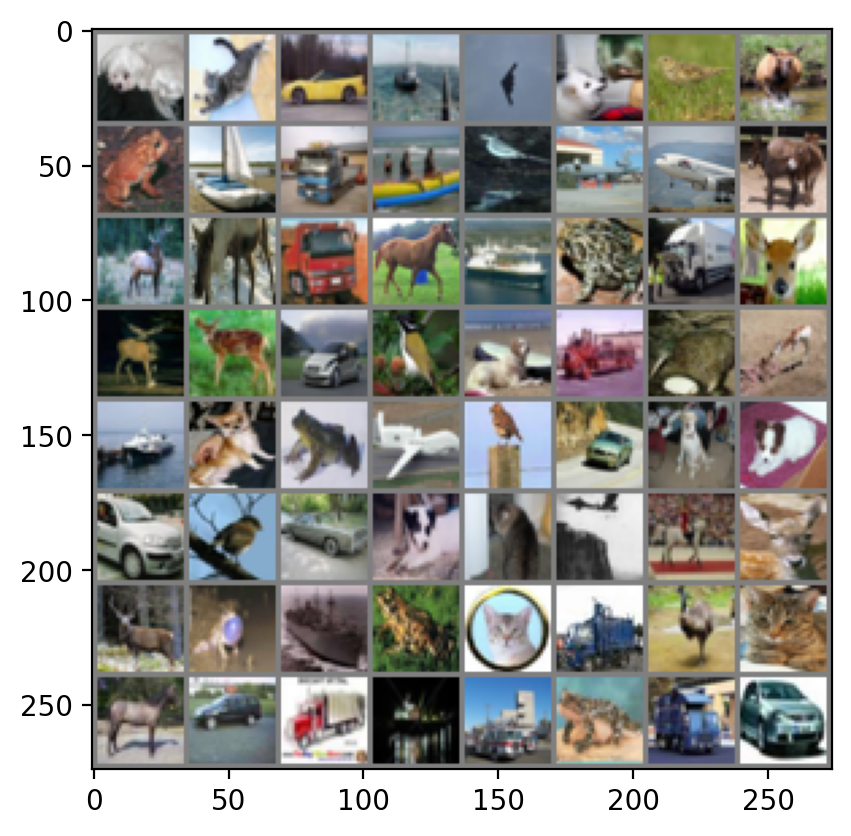

In [6]:
imshow(utils.make_grid(images))


> **Exercise:** Create a validation set using the 20% of train images

In [7]:
# YOUR CODE HERE
from torch.utils.data import Subset

validation_size = 0.2  # 20% of the training set

# Calculate the number of samples to include in the validation set
num_train = len(trainset)
num_val = int(validation_size * num_train)
num_train_remaining = num_train - num_val

# Split the indices into training and validation sets
train_indices, val_indices = torch.utils.data.random_split(
    range(num_train), [num_train_remaining, num_val]
)

# Create data loaders for training and validation sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, sampler=train_sampler, num_workers=2
)

valloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, sampler=val_sampler, num_workers=2
)


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [8]:
Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [9]:
import torch.nn as nn

class Lenet5(nn.Module):
    def __init__(self, dimx, nlabels): 
        super().__init__()

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # Max pool layer (reduces size to 14x14x6)
        self.pool1 = nn.MaxPool2d(2, 2)

        # convolutional layer (sees 14x14x6 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer (reduces size to 5x5x16)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx - 4) / 2 - 4) / 2)
        
    def forward(self, x):
        # Pass the input tensor through the first convolutional layer and max-pooling
        x = self.conv1(x)
        x = self.relu(x) 
        x = self.pool1(x)
        
        # Pass the tensor through the second convolutional layer and max-pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Flatten the tensor into a vector of appropriate dimension
        x = x.view(-1, 16 * 5 * 5)
        
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        x = self.logsoftmax(x) 
        return x

# Create an instance of Lenet5
dimx = 32  # Dimension of input images
nlabels = 10  # Number of output labels
model = Lenet5(dimx, nlabels)
print(model)

 


Lenet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
)


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [10]:
#YOUR CODE HERE
import torch
import torch.optim as optim
import torch.nn.functional as F

class Lenet5(nn.Module):
    def __init__(self, dimx, nlabels): 
        super().__init__()

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # Max pool layer (reduces size to 14x14x6)
        self.pool1 = nn.MaxPool2d(2, 2)

        # convolutional layer (sees 14x14x6 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer (reduces size to 5x5x16)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx - 4) / 2 - 4) / 2)
        
    def forward(self, x):
        # Pass the input tensor through the first convolutional layer and max-pooling
        x = self.conv1(x)
        x = self.relu(x) 
        x = self.pool1(x)
        
        # Pass the tensor through the second convolutional layer and max-pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Flatten the tensor into a vector of appropriate dimension
        x = x.view(-1, 16 * 5 * 5)
        
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        x = self.logsoftmax(x) 
        return x
    
    def train_model(self, trainloader, valloader, criterion, optimizer, num_epochs=10):
        train_losses= []
        val_losses=[]
        for epoch in range(num_epochs):
            start_time = time.time()
            # Training
            self.train()
            running_loss = 0.0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            train_loss = running_loss / len(trainloader)
            train_losses.append(train_loss)
            
            # Validation
            self.eval()
            val_loss = self.evaluate_loss(valloader, criterion)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Time per epoch: {time.time() - start_time}")
            
        return train_losses, val_losses
        
    def evaluate_loss(self, dataloader, criterion):
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def evaluate_accuracy(self, dataloader):
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total


> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

Epoch 1/5, Train Loss: 1.7086055131912232, Val Loss: 1.4755577122329906, Time per epoch: 27.698603868484497
Epoch 2/5, Train Loss: 1.3672590336799622, Val Loss: 1.2912074714709239, Time per epoch: 27.698693990707397
Epoch 3/5, Train Loss: 1.2401098585128785, Val Loss: 1.2397149622819985, Time per epoch: 29.141005516052246
Epoch 4/5, Train Loss: 1.1550862341880799, Val Loss: 1.1773545214325, Time per epoch: 27.917189598083496
Epoch 5/5, Train Loss: 1.0922892888069153, Val Loss: 1.1631077744398908, Time per epoch: 27.932064533233643


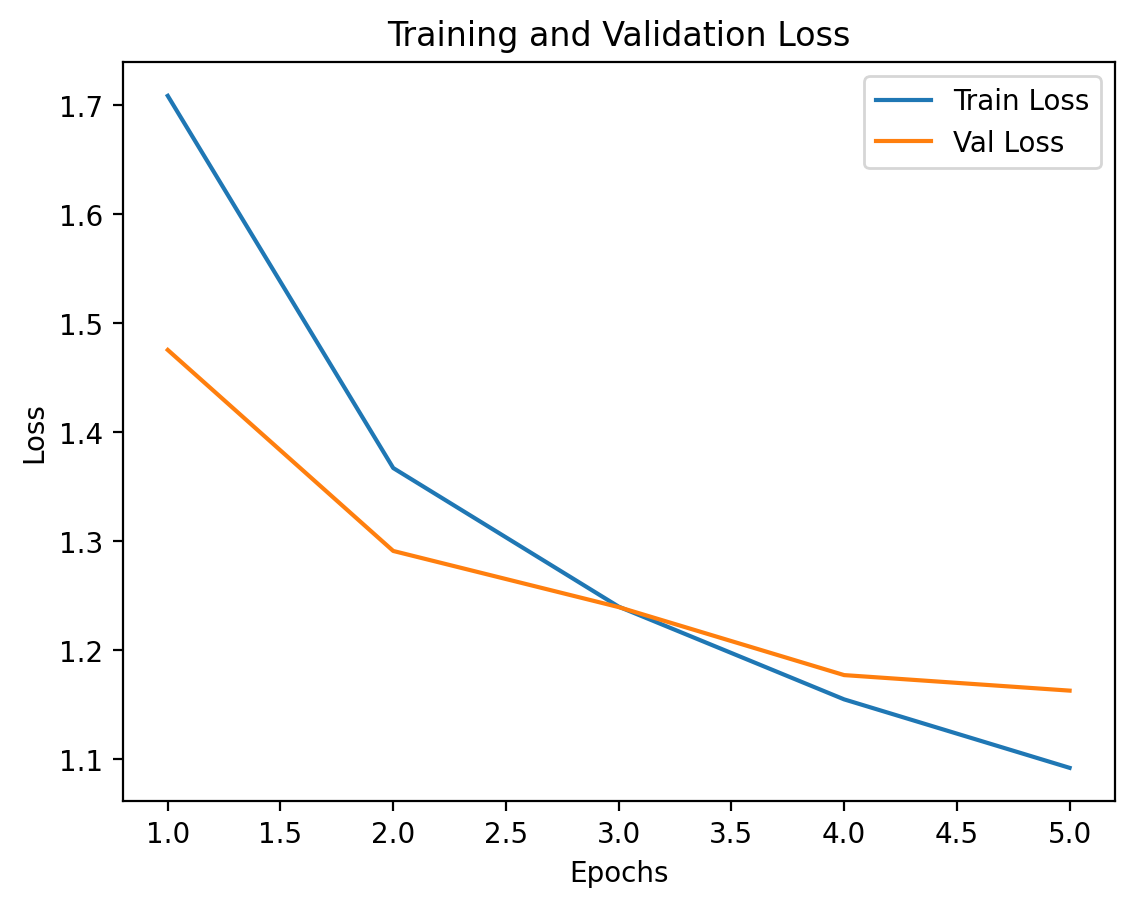

Train Accuracy: 0.628175, Val Accuracy: 0.588


In [11]:
# Define the model, criterion, and optimizer
dimx = 32
nlabels = 10
my_CNN = Lenet5(dimx, nlabels)

criterion = nn.NLLLoss()
optimizer = optim.Adam(my_CNN.parameters(), lr=0.001)

# Train the model for 5 epochs
train_losses, val_losses = my_CNN.train_model(trainloader, valloader, criterion, optimizer, num_epochs=5)

# Plot the losses
plt.plot(range(1, 6), train_losses, label='Train Loss')
plt.plot(range(1, 6), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate performance
train_accuracy = my_CNN.evaluate_accuracy(trainloader)
val_accuracy = my_CNN.evaluate_accuracy(valloader)
print(f"Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [12]:
class Lenet5_extended_GPU(Lenet5):
    
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels)  
        
        self.lr = lr # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()             
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)  
                self.optim.zero_grad()  # Reset Gradients
                output = self.forward(images)
                loss = self.criterion(output, labels)
                running_loss += loss.item()
                loss.backward()  # Compute gradients
                self.optim.step()  # Update network parameters
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            with torch.no_grad():            
                running_loss = 0.
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            if e % 1 == 0:
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      % (e, self.loss_during_training[-1], self.valid_loss_during_training[-1], 
                         (time.time() - start_time)))
                
    def eval_performance(self, dataloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [13]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,valloader)

Epoch 0. Training loss: 1.683760, Validation loss: 1.489329, Time per epoch: 27.574049 seconds
Epoch 1. Training loss: 1.398545, Validation loss: 1.375135, Time per epoch: 27.629589 seconds
Epoch 2. Training loss: 1.280731, Validation loss: 1.247840, Time per epoch: 29.015924 seconds
Epoch 3. Training loss: 1.188775, Validation loss: 1.205078, Time per epoch: 28.436166 seconds
Epoch 4. Training loss: 1.123924, Validation loss: 1.161908, Time per epoch: 27.858685 seconds


tensor(0.6212)
tensor(0.5857)


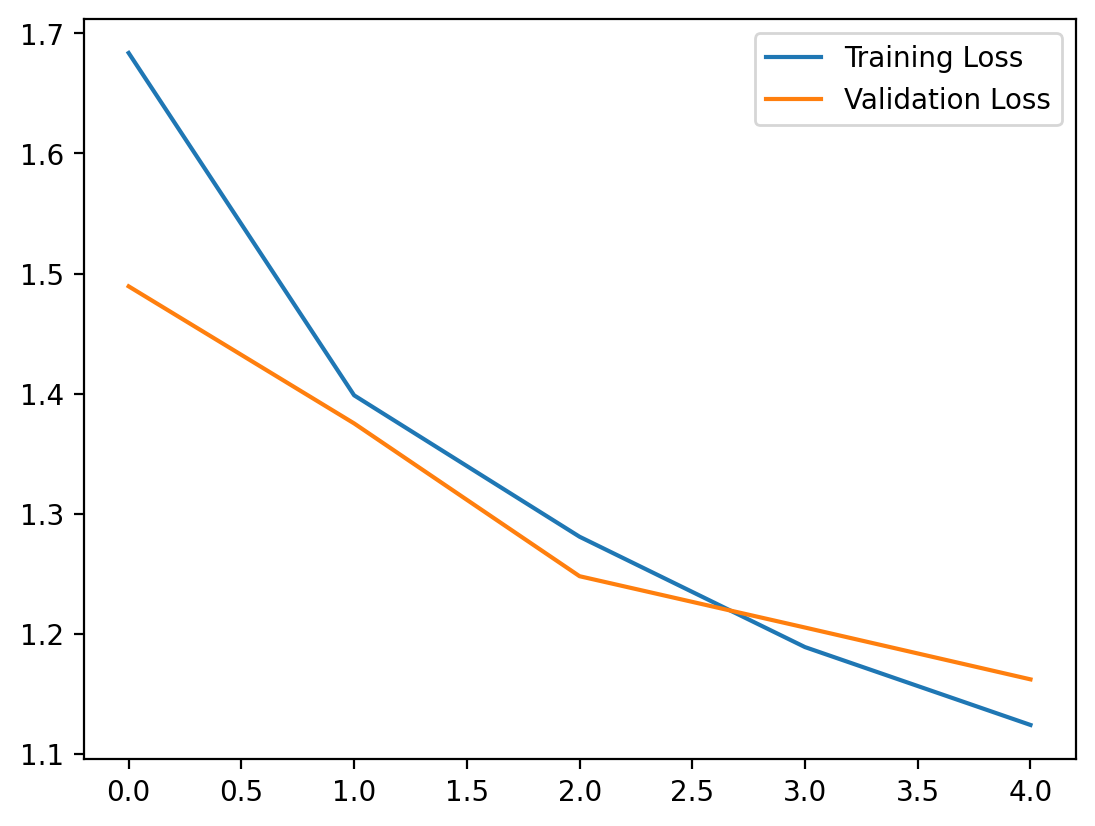

In [14]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(valloader))

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

Epoch 0. Training loss: 1.658452, Validation loss: 1.449829, Time per epoch: 27.802434 seconds
Epoch 1. Training loss: 1.384431, Validation loss: 1.304817, Time per epoch: 27.887396 seconds
Epoch 2. Training loss: 1.267673, Validation loss: 1.245694, Time per epoch: 27.877995 seconds
Epoch 3. Training loss: 1.186606, Validation loss: 1.213219, Time per epoch: 27.704460 seconds
Epoch 4. Training loss: 1.123246, Validation loss: 1.149260, Time per epoch: 27.683343 seconds
Epoch 5. Training loss: 1.071363, Validation loss: 1.135992, Time per epoch: 27.503179 seconds
Epoch 6. Training loss: 1.019019, Validation loss: 1.120865, Time per epoch: 27.567956 seconds
Epoch 7. Training loss: 0.977655, Validation loss: 1.112543, Time per epoch: 28.181132 seconds
Epoch 8. Training loss: 0.937865, Validation loss: 1.099554, Time per epoch: 27.941200 seconds
Epoch 9. Training loss: 0.902150, Validation loss: 1.117321, Time per epoch: 27.686421 seconds
Epoch 10. Training loss: 0.869838, Validation loss

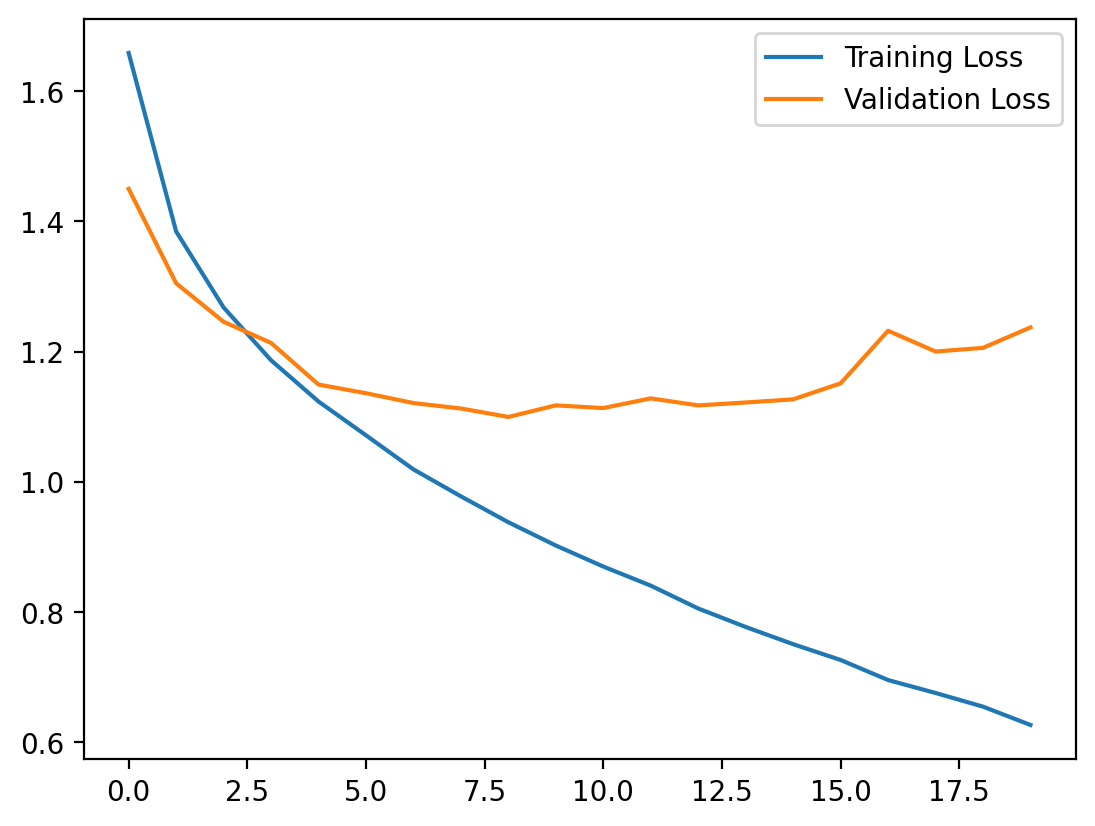

In [15]:
#YOUR CODE HERE (Check CNN overfiting)

my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=20,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,valloader)

plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(valloader))


In [16]:
#YOUR CODE HERE (Regularize the network)

class Lenet5(nn.Module):
    def __init__(self, dimx, nlabels, dropout_prob=0.2): 
        super().__init__()

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # Max pool layer (reduces size to 14x14x6)
        self.pool1 = nn.MaxPool2d(2, 2)

        # convolutional layer (sees 14x14x6 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer (reduces size to 5x5x16)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx - 4) / 2 - 4) / 2)
        
    def forward(self, x):
        # Pass the input tensor through the first convolutional layer and max-pooling
        x = self.conv1(x)
        x = self.relu(x) 
        x = self.pool1(x)
        
        # Pass the tensor through the second convolutional layer and max-pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Flatten the tensor into a vector of appropriate dimension
        x = x.view(-1, 16 * 5 * 5)
        
        # Pass the tensor through the Dense Layers with dropout
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        
        x = self.logsoftmax(x) 
        return x


class Lenet5_extended_GPU(Lenet5):
    
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels)  
        
        self.lr = lr # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()             
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)  
                self.optim.zero_grad()  # Reset Gradients
                output = self.forward(images)
                loss = self.criterion(output, labels)
                running_loss += loss.item()
                loss.backward()  # Compute gradients
                self.optim.step()  # Update network parameters
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            with torch.no_grad():            
                running_loss = 0.
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            if e % 1 == 0:
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      % (e, self.loss_during_training[-1], self.valid_loss_during_training[-1], 
                         (time.time() - start_time)))
                
    def eval_performance(self, dataloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)


Epoch 0. Training loss: 1.757997, Validation loss: 1.541997, Time per epoch: 27.409392 seconds
Epoch 1. Training loss: 1.469321, Validation loss: 1.453201, Time per epoch: 27.795888 seconds
Epoch 2. Training loss: 1.362040, Validation loss: 1.350846, Time per epoch: 27.938078 seconds
Epoch 3. Training loss: 1.283079, Validation loss: 1.290377, Time per epoch: 27.547677 seconds
Epoch 4. Training loss: 1.228759, Validation loss: 1.273544, Time per epoch: 28.186528 seconds
Epoch 5. Training loss: 1.179246, Validation loss: 1.229713, Time per epoch: 28.003149 seconds
Epoch 6. Training loss: 1.141107, Validation loss: 1.207947, Time per epoch: 28.046872 seconds
Epoch 7. Training loss: 1.107879, Validation loss: 1.214007, Time per epoch: 27.834045 seconds
Epoch 8. Training loss: 1.078659, Validation loss: 1.214087, Time per epoch: 27.984561 seconds
Epoch 9. Training loss: 1.055581, Validation loss: 1.190864, Time per epoch: 27.977775 seconds
Epoch 10. Training loss: 1.031507, Validation loss

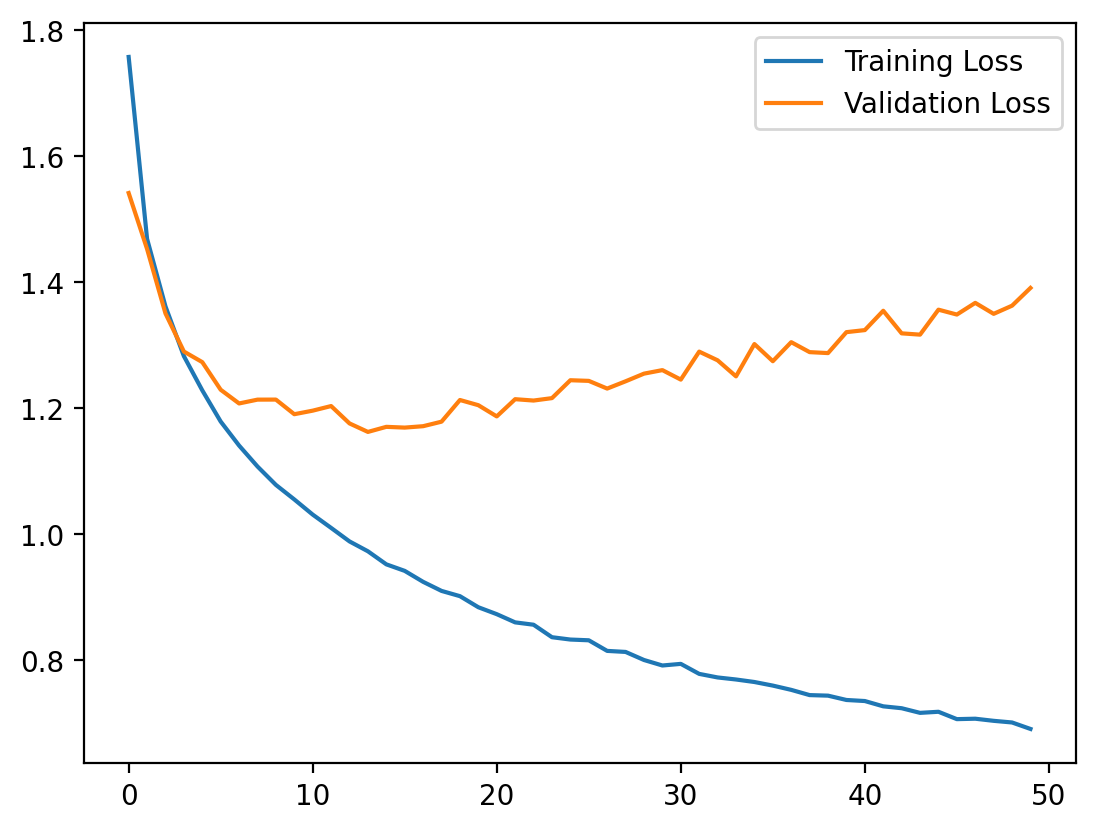

In [17]:
# First: evaluating with the dropout layers 

my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=50,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,valloader)

plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(valloader))



Epoch 0. Training loss: 1.775139, Validation loss: 1.560929, Time per epoch: 27.289138 seconds
Epoch 1. Training loss: 1.501319, Validation loss: 1.450905, Time per epoch: 27.670334 seconds
Epoch 2. Training loss: 1.384990, Validation loss: 1.353489, Time per epoch: 27.738028 seconds
Epoch 3. Training loss: 1.300618, Validation loss: 1.295221, Time per epoch: 27.611511 seconds
Epoch 4. Training loss: 1.234841, Validation loss: 1.273195, Time per epoch: 27.756421 seconds
Epoch 5. Training loss: 1.180668, Validation loss: 1.224510, Time per epoch: 28.162633 seconds
Epoch 6. Training loss: 1.142748, Validation loss: 1.204309, Time per epoch: 27.801151 seconds
Epoch 7. Training loss: 1.102726, Validation loss: 1.205911, Time per epoch: 27.874781 seconds
Epoch 8. Training loss: 1.077365, Validation loss: 1.175913, Time per epoch: 27.807479 seconds
Epoch 9. Training loss: 1.045943, Validation loss: 1.184659, Time per epoch: 27.889235 seconds


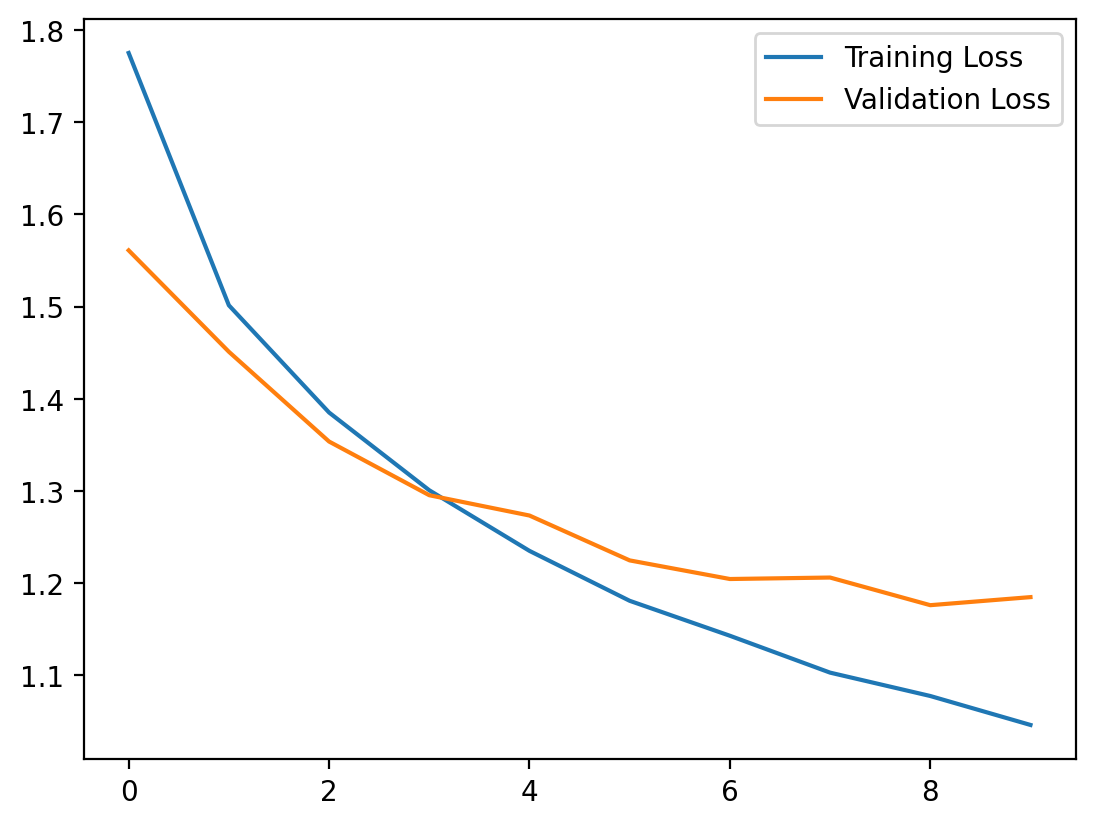

In [18]:
# Second: after observing the new plot of validation loss, we decided 10 epochs for doing early stopping and avoid overfitting 

my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=10,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,valloader)

plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()



In [19]:
#YOUR CODE HERE (Check the CNN performance)
print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(valloader))
print(my_CNN_GPU.eval_performance(testloader))


tensor(0.6420)
tensor(0.5883)
tensor(0.5921)


### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

In [20]:
#YOUR CODE HERE
class MLP(nn.Module):
    def __init__(self, input_dim, nlabels, dropout_prob=0.2): 
        super().__init__()
        # Linear layers
        self.linear1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(128, nlabels)
    
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Flatten the tensor into a vector of appropriate dimension
        x = x.view(-1, self.num_flat_features(x))
        
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        
        x = self.logsoftmax(x) 
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def train_model(self, trainloader, valloader, criterion, optimizer, num_epochs=10):
        train_losses= []
        val_losses=[]
        for epoch in range(num_epochs):
            start_time = time.time()
            # Training
            self.train()
            running_loss = 0.0
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            train_loss = running_loss / len(trainloader)
            train_losses.append(train_loss)
            
            # Validation
            self.eval()
            val_loss = self.evaluate_loss(valloader, criterion)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Time per epoch: {time.time() - start_time}")
            
        return train_losses, val_losses
        
    def evaluate_loss(self, dataloader, criterion):
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def evaluate_accuracy(self, dataloader):
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

In [21]:
# Define the model, criterion, and optimizer
input_dim = 32 * 32 * 3
nlabels = 10  # Example number of output labels

mlp_model = MLP(input_dim, nlabels)

criterion = nn.NLLLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Train the model for 5 epochs
train_losses, val_losses = mlp_model.train_model(trainloader, valloader, criterion, optimizer, num_epochs=20)





Epoch 1/20, Train Loss: 1.7496978515625, Val Loss: 1.5857562737859738, Time per epoch: 27.293328285217285
Epoch 2/20, Train Loss: 1.5798650220870971, Val Loss: 1.4922219446510265, Time per epoch: 27.307633876800537
Epoch 3/20, Train Loss: 1.5064230068206788, Val Loss: 1.4600364395007965, Time per epoch: 26.93831491470337
Epoch 4/20, Train Loss: 1.4482547311782836, Val Loss: 1.4292289610880955, Time per epoch: 26.915188312530518
Epoch 5/20, Train Loss: 1.401307086277008, Val Loss: 1.4086257591369047, Time per epoch: 26.769240617752075
Epoch 6/20, Train Loss: 1.362700223350525, Val Loss: 1.400891341980855, Time per epoch: 26.83399724960327
Epoch 7/20, Train Loss: 1.328609283351898, Val Loss: 1.386957943819131, Time per epoch: 26.945486783981323
Epoch 8/20, Train Loss: 1.2912983308792114, Val Loss: 1.4055068409366973, Time per epoch: 26.966071605682373
Epoch 9/20, Train Loss: 1.268838565635681, Val Loss: 1.3772068813348273, Time per epoch: 27.004033088684082
Epoch 10/20, Train Loss: 1.237

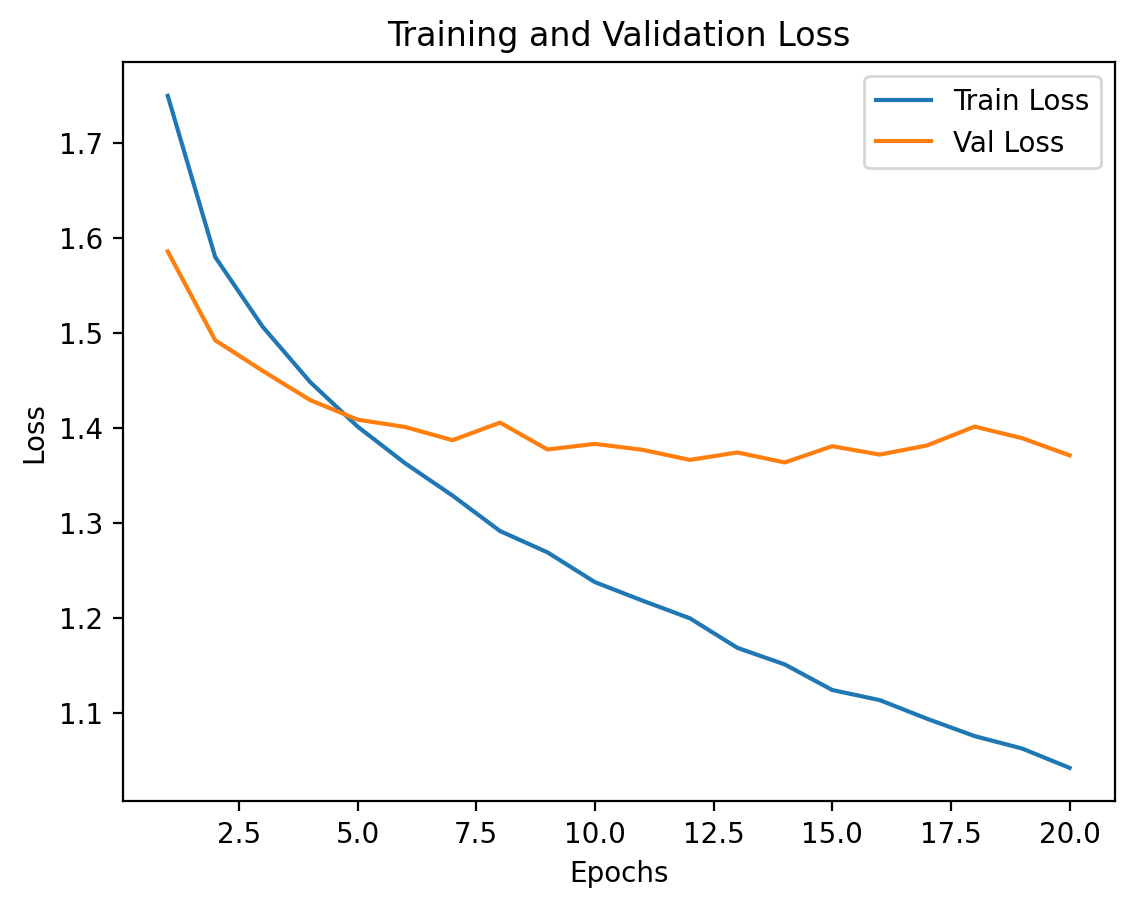

In [22]:
# Plot the losses
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
# Early stopping: 10 epochs
input_dim = 32 * 32 * 3
nlabels = 10  # Example number of output labels

mlp_model = MLP(input_dim, nlabels)

criterion = nn.NLLLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Train the model for 5 epochs
train_losses, val_losses = mlp_model.train_model(trainloader, valloader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 1.744425704574585, Val Loss: 1.5865738186866614, Time per epoch: 27.10928177833557
Epoch 2/10, Train Loss: 1.5754906459808349, Val Loss: 1.5008525696529704, Time per epoch: 28.465286016464233
Epoch 3/10, Train Loss: 1.503235019683838, Val Loss: 1.4839808189185562, Time per epoch: 26.749752283096313
Epoch 4/10, Train Loss: 1.4522774877548217, Val Loss: 1.4431606462806652, Time per epoch: 26.978747844696045
Epoch 5/10, Train Loss: 1.4004153032302857, Val Loss: 1.3934227493917866, Time per epoch: 27.069231033325195
Epoch 6/10, Train Loss: 1.3677454746246338, Val Loss: 1.4080309222458274, Time per epoch: 27.09246587753296
Epoch 7/10, Train Loss: 1.3299530038833618, Val Loss: 1.4132417895991332, Time per epoch: 26.788572549819946
Epoch 8/10, Train Loss: 1.2971420676231384, Val Loss: 1.382081431947696, Time per epoch: 26.984933376312256
Epoch 9/10, Train Loss: 1.263990272808075, Val Loss: 1.3776089370630349, Time per epoch: 26.998254776000977
Epoch 10/10, Train Loss: 

In [24]:
# Evaluate performance
train_accuracy = mlp_model.evaluate_accuracy(trainloader)
val_accuracy = mlp_model.evaluate_accuracy(valloader)
test_accuracy = mlp_model.evaluate_accuracy(testloader)
print(f"Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}")

Train Accuracy: 0.62575, Val Accuracy: 0.5151, Test Accuracy: 0.5227
